# Lab 4: Chronos - learning the language of time series
This notebook uses content from [Chronos GitHub](https://github.com/amazon-science/chronos-forecasting).

Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss.

Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.

Chronos demonstrates impressive zero-shot forecasting performance across a wide range of datasets. More specifically, it achieves comparable and occasionally superior zero-shot performance on new datasets, relative to methods that were trained specifically on those datasets. In a comprehensive evaluation across 42 datasets, see [1](https://arxiv.org/html/2403.07815v1) and [2](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting), Chronos establishes itself as a benchmark for zero-shot forecasting, surpassing both traditional models and task-specific deep learning approaches. Chronos can leverage time series data from diverse domains to improve zero-shot accuracy on unseen forecasting tasks.

For details on Chronos models, training data and procedures, and experimental results, please refer to the paper [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815).

## Architecture
Chronos models are based on the [T5 architecture](https://arxiv.org/abs/1910.10683). The only difference is in the vocabulary size: Chronos-T5 models use 4096 different tokens, compared to 32128 of the original T5 models, resulting in fewer parameters. The following table provides links to corresponding Chronos models on Huggingface model hub.

|Model|Parameters|Based on|
|---|---|---|
|[**chronos-t5-tiny**](https://huggingface.co/amazon/chronos-t5-tiny)|8M|[t5-efficient-tiny](https://huggingface.co/google/t5-efficient-tiny)|
|[**chronos-t5-mini**](https://huggingface.co/amazon/chronos-t5-mini)|20M|[t5-efficient-mini](https://huggingface.co/google/t5-efficient-mini)|
|[**chronos-t5-small**](https://huggingface.co/amazon/chronos-t5-small)|46M|[t5-efficient-small](https://huggingface.co/google/t5-efficient-small)|
|[**chronos-t5-base**](https://huggingface.co/amazon/chronos-t5-base)|200M|[t5-efficient-base](https://huggingface.co/google/t5-efficient-base)|
|[**chronos-t5-large**](https://huggingface.co/amazon/chronos-t5-large)|710M|[t5-efficient-large](https://huggingface.co/google/t5-efficient-large)|

The following diagram from the Chronos GitHub shows the high-level architecture of Chronos:

![](../img/chronos-main-figure.png)

## Zero-shot inference

This notebooks demonstrate how to use a pretrained Chronos model for **zero-shot** inference for predicting time series. Unlike local statistical models or task-specific models that you need to train on particular historical datasets, Chronos generates zero-shot probobalistic forecaset for time series that its models have never seen during training.

## Recommended usage
The recommended way of using Chronos for production use cases is through [AutoGluon](https://auto.gluon.ai/), which features ensembling with other statistical and machine learning models for time series forecasting as well as seamless deployments on AWS with SageMaker. The next [notebook](./lab5_autogluon.ipynb) in this workshop demonstrates usage of AutoGluon for time series forecast including Chronos.

This notebooks shows how to use Chronos models hosted as SageMaker real-time endpoints.

---

## Import packages

In [1]:
%pip install -Uq s3fs sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.
langchain-aws 0.1.15 requires boto3<1.35.0,>=1.34.131, but you have boto3 1.35.7 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import sagemaker
from sagemaker.jumpstart.model import JumpStartModel
import boto3
import zipfile
from dateutil.parser import parse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading
import tqdm
import asyncio
from time import gmtime, strftime, sleep
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import (
interact, interactive, fixed, interact_manual,
IntSlider, FloatSlider, Checkbox, Dropdown, DatePicker
)

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Set literals and general variables

In [7]:
%store -r
%store

try:
    domain_id
except NameError:
    print("""\033[91m 
    **************************************************************************************
    domain_id is not defined!
    Set it manually or run the "Setup notebook environment" section of the lab 1 notebook
    **************************************************************************************
    \033[0m""")

Stored variables and their in-db values:
domain_id                     -> 'd-gp9zw7c7fx1i'
region                        -> 'us-east-1'
space_name                    -> 'ts-space'
user_profile_name             -> 'studio-user-ts-d99c46b0'


In [8]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
sm = boto3.client("sagemaker")

In [9]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "chronos-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "chronos"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [10]:
s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [11]:
dataset_zip_file_name = "LD2011_2014.txt.zip"
s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [12]:
os.makedirs("./data", exist_ok=True)

s3_client = boto3.client("s3")
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
)

In [13]:
zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
zip_ref.extractall("./data")
zip_ref.close()
dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])

In [14]:
# see what is inside the file
# !head -n 2 {dataset_path} 

## Explore and preprocess data

In [15]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [16]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


The following code resamples the dataset to 1H intervals to reduce the number of data points and smoothen the data. You can experiment with any other sampling interval. Remember to ajust the divider for resampled kW data.

In [17]:
# resample to 2h intervals
freq = "2H"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8
num_timeseries = df_raw.shape[1]
data_kw = df_raw.resample(freq).sum() / div
timeseries = []

for i in tqdm.trange(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

100%|██████████| 370/370 [00:00<00:00, 2388.35it/s]


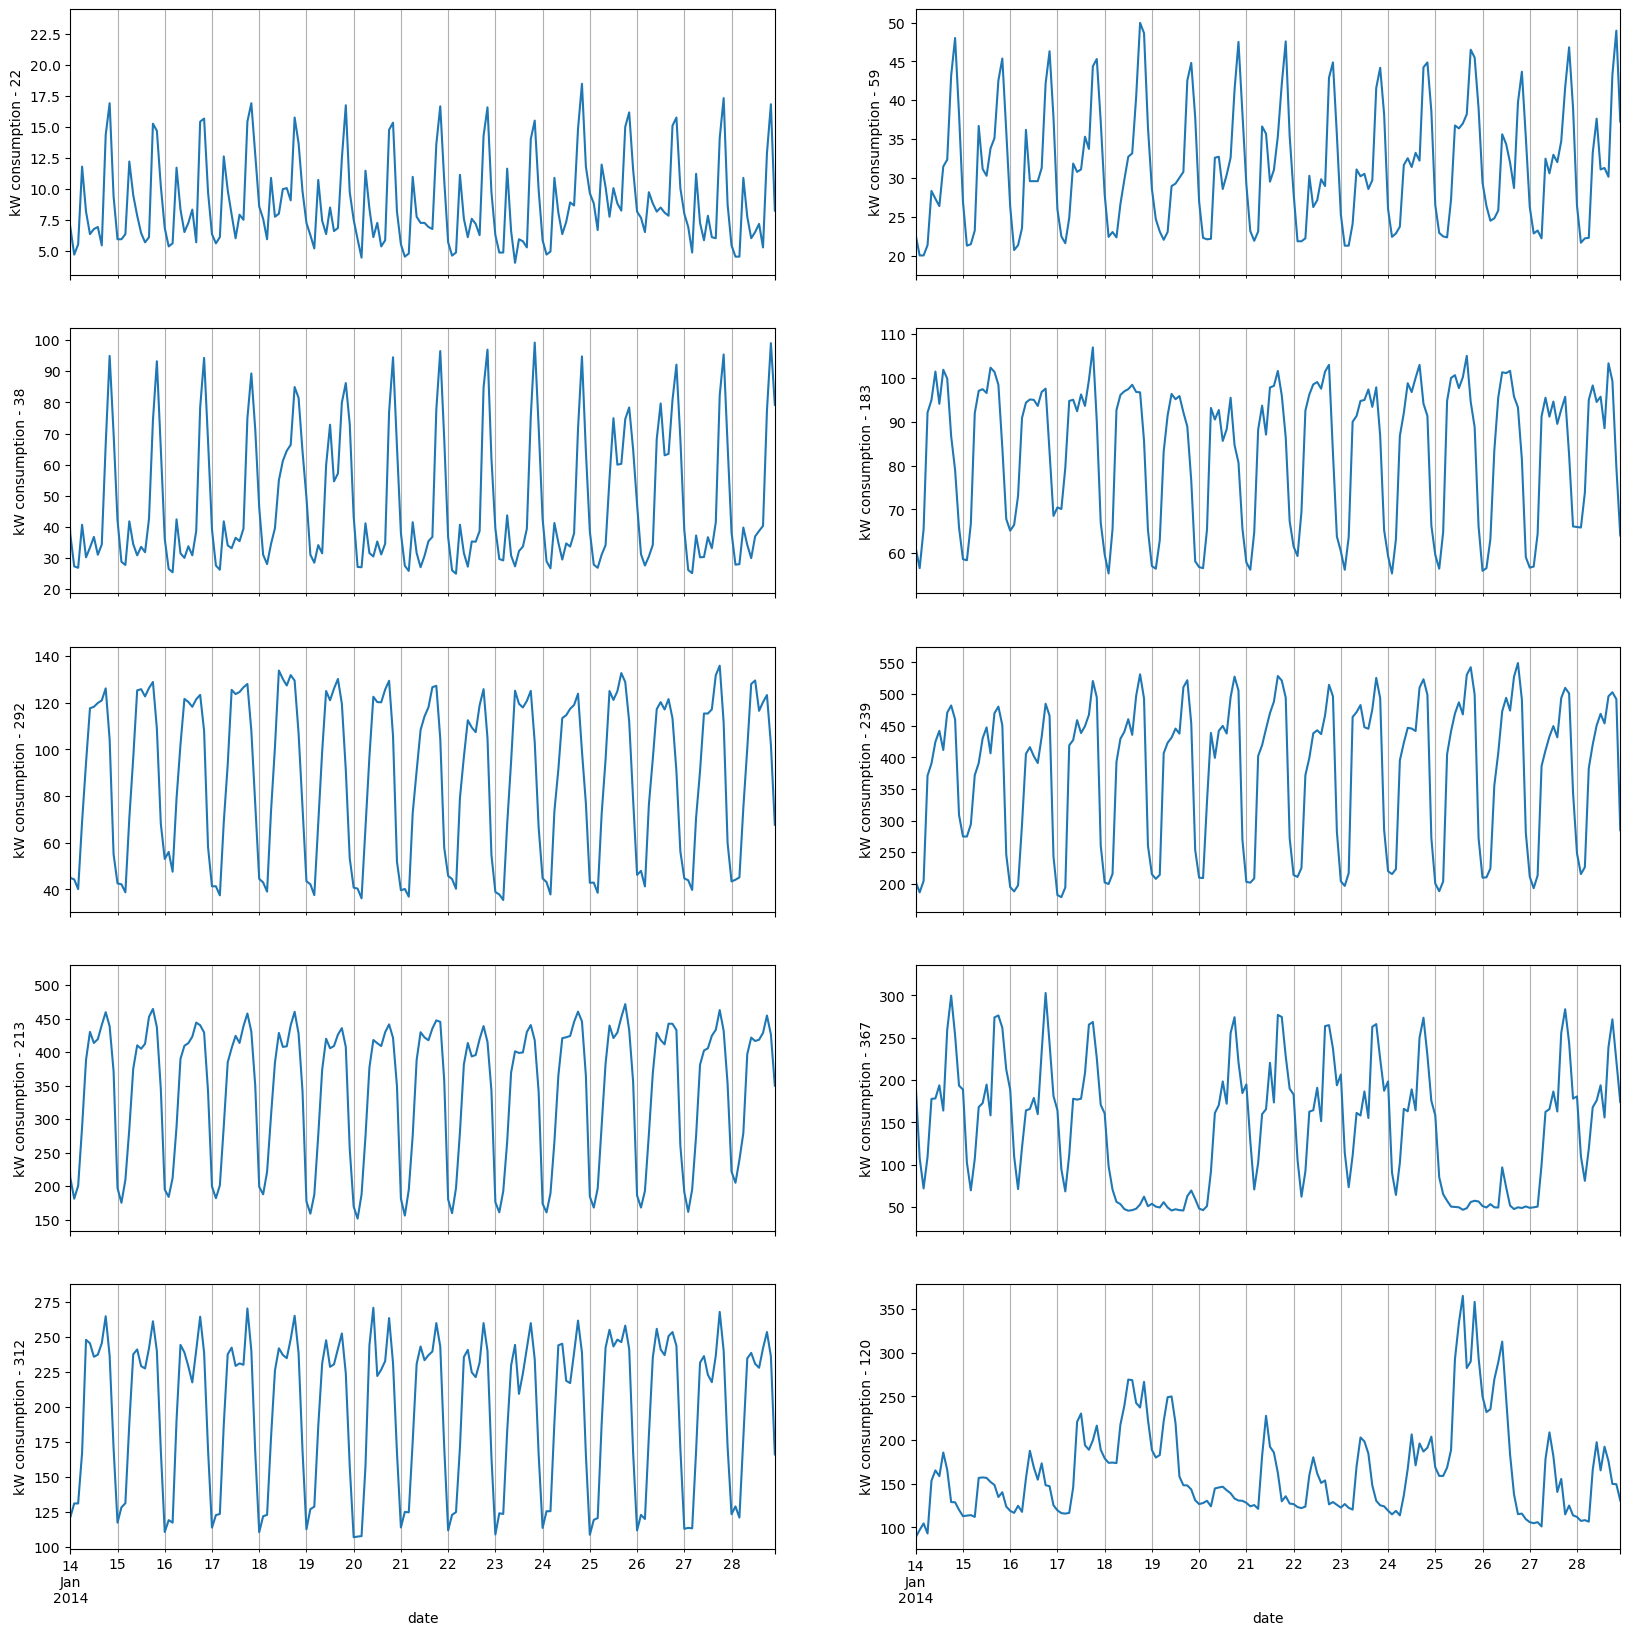

In [18]:
# show random 10 timeseries for 28 day period
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i, ts_id in enumerate(np.random.randint(1, data_kw.shape[1], size=10).tolist()):
    timeseries[ts_id].loc["2014-01-01":"2014-01-28"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts_id}")
    axx[i].grid(which="minor", axis="x")

## Deploy Chronos models
This notebook uses the [`JumpStartModel`](https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-foundation-models-use-python-sdk.html) class in the SageMaker Python SDK. SageMaker JumpStart models can be deployed using the model ID. 

You can also deploy a Chronos model directly from the Studio UI. For example, open the link constructed by the following code cell to see a Chronos model in the SageMaker JumpStart.

This notebook uses SageMaker Python SDK to deploy three Chronos models as SageMaker real-time inference endpoints.

In [300]:
# Show the JumpStart model link
model_to_show = 'chronos-t5-small'
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/jumpstart/SageMakerPublicHub/Model/autogluon-forecasting-{}">JumpStart Chronos model</a> in the Studio UI</b>'.format(
            domain_id, region, model_to_show))
)

You need an GPU-instance for an endpoint to run Chronos `large`, `base`, and `small` models. You can run `mini` and `tiny` models on a CPU-based instance.

### Check quotas for endpoint instances
Before deploying models, you need to check if you have an account-level quota for the specific GPU-instances like `ml.g5.*`.

In [19]:
def check_quota(models):
    quotas_client = boto3.client("service-quotas")

    for m in models:
        r = quotas_client.get_service_quota(
            ServiceCode="sagemaker",
            QuotaCode=m["quota_code"],
        )
    
        q = r["Quota"]["Value"]
        n = r["Quota"]["QuotaName"]
        min_n = m["min_number"] if m.get("min_number") else 1

        print(f"WARNING: Quota {q} for {n} < required {min_n}" if q < min_n else f"SUCCESS: Quota {q} for {n} >= required {min_n}")
        

The following dictionary defines which models this notebooks is going to deploy and what ML instances is used. If you don't have sufficient quota for the corresponding ML instance, set the value of `deploy` key to `False`. As a minimal setup, you can deploy only the `chronos-t5-small` model to experiment with the inference.

In [20]:
model_map = [
    {"model":"chronos-t5-small",
     "instance":"ml.g5.xlarge",
     "quota_code":"L-1928E07B",
     "deploy": True
    },
    {"model":"chronos-t5-base",
     "instance":"ml.g5.2xlarge",
     "quota_code":"L-9614C779",
     "deploy": True
    },
    {"model":"chronos-t5-large",
     "instance":"ml.g5.4xlarge",
     "quota_code":"L-C1B9A48D",
     "deploy": True
    },
]

In [21]:
# check if you have account-level quota for the required inference instance
check_quota(model_map)

SUCCESS: Quota 4.0 for ml.g5.xlarge for endpoint usage >= required 1
SUCCESS: Quota 2.0 for ml.g5.2xlarge for endpoint usage >= required 1
SUCCESS: Quota 2.0 for ml.g5.4xlarge for endpoint usage >= required 1


<div class="alert alert-info">
If you using an AWS-provisioned workshop account, you cannot change quotas. If you don't have sufficient quotas for <code>ml.g5.*</code>, try <code>ml.g4dn.2xlarge </code> or <code>ml.g4dn.4xlarge </code> instances.
</div>

### Custom predictor class
Implement a wrapper for the Chronos predictor to conveniently pass Pandas series to the predictor and convert the response also to Pandas series.

Chronos model interface receives the following JSON as the input. You specify target time series and inference parameters like prediction length and quantiles to generate:

```
{
    "inputs": [
        {"target": [0.0, 4.0, 5.0, 1.5, -3.0, -5.0, -3.0, 1.5, 5.0, 4.0, 0.0, -4.0, -5.0, -1.5, 3.0, 5.0, 3.0, -1.5, -5.0, -4.0]}
    ],
    "parameters": {
        "prediction_length": 10,
        "quantile_levels": [0.1, 0.5, 0.9]
    }
}
```

The model output is a JSON document which contains the predicted time series per quantile and the mean prediction:
```
{
    "predictions": [
        {
            "mean": [-0.0, 3.5, 4.2, 1.7, -1.5, -3.5, -1.9, 1.3, 3.8, 3.4],
            "0.1": [-2.4, 1.5, 2.2, 0.0, -4.9, -5.0, -4.9, -1.5, 1.4, 0.9],
            "0.5": [-0.0, 3.0, 4.0, 1.5, -1.5, -4.9, -2.8, 1.5, 4.5, 3.0],
            "0.9": [1.7, 5.6, 5.5, 3.1, 0.4, 0.0, 3.0, 3.2, 5.0, 5.0]
        }
    ]
}
```

The following code implements a custome predictor class derived from the SageMaker Python SDK [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor).

In [22]:
from sagemaker.serializers import IdentitySerializer

class ChronosPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        prediction_length=64,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`
        ts -- `pandas.Series` object, the time series to predict
        prediction_length -- number of data points to predict, dimension is the sampling interval
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: a `pandas.DataFrame` object containing the predictions
        """
        prediction_start = ts.index[-1] + ts.index.freq
        req = self.__encode_request(ts, prediction_length, quantiles)
        
        res = super(ChronosPredictor, self).predict(req)
        
        return self.__decode_response(res, ts.index.freq, prediction_start)

    def __encode_request(self, ts, prediction_length, quantiles):
        target = series_to_dict(ts)
        parameters = {
            "prediction_length": prediction_length,
            "quantile_levels": quantiles,
        }

        http_request_data = {"inputs": [target], "parameters": parameters}
    
        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_start):
        # the example sends one time series and receives one in return
        # however, if possible to pass multiple time series as predictions be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_index = pd.date_range(
            start=prediction_start, freq=freq, periods=len(predictions["mean"])
        )
    
        return pd.DataFrame(
            data=predictions, index=prediction_index
        )

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts):
    return {"target": encode_target(ts)}

### Deploy endpoints
Now use `JumpStartModel` and the custome `ChronosPredictor` to create and deploy Chronos models.

In [23]:
chronos_predictors = {}

for m in model_map:
    if m['deploy']:
        model = JumpStartModel(
            model_id="autogluon-forecasting-" + m["model"],
            model_version="1.0.0",
            predictor_cls=ChronosPredictor,
        )
    
        print(f"Start deploying {m['model']} on {m['instance']}")
        chronos_predictors[m["model"]] =  model.deploy(
            instance_type=m["instance"],  # single-GPU g5, p3, g4dn instances supported
            wait=False,
        )

Start deploying chronos-t5-small on ml.g5.xlarge
Start deploying chronos-t5-base on ml.g5.2xlarge
Start deploying chronos-t5-large on ml.g5.4xlarge


Wait until all endpoints are in service. The deployment takes about 5-7 minutes.

In [ ]:
%%time

# Wait until all endpoints have the status InService
for p in chronos_predictors.values():
    waiter = sagemaker_session.sagemaker_client.get_waiter('endpoint_in_service')
    waiter.wait(EndpointName=p.endpoint_name)

CPU times: user 80 ms, sys: 6.47 ms, total: 86.5 ms
Wall time: 6min 1s


## Using Chronos real-time endpoints

### Generate predictions
Run a sample prediction to test an endpoint.

In [28]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day
context_length = prediction_length * 12
forecast_quantiles = [0.10, 0.5, 0.90]

In [29]:
ts = timeseries[0][len(timeseries[0])-context_length:]

In [30]:
ts

2014-10-09 02:00:00    1.903553
2014-10-09 04:00:00    2.062183
2014-10-09 06:00:00    1.744924
2014-10-09 08:00:00    1.744924
2014-10-09 10:00:00    1.110406
                         ...   
2014-12-31 16:00:00    2.379442
2014-12-31 18:00:00    2.220812
2014-12-31 20:00:00    2.379442
2014-12-31 22:00:00    2.062183
2015-01-01 00:00:00    0.317259
Freq: 2H, Name: MT_001, Length: 1008, dtype: float64

Chronos generates a forecast for `prediction_length` data points starting from the end of the provided time series:

In [31]:
chronos_predictors['chronos-t5-small'].predict(
    ts=ts,
    prediction_length=prediction_length,
    quantiles=forecast_quantiles
)

,mean,0.1,0.5,0.9
2015-01-01 02:00:00,0.750000,0.324074,0.324074,2.067901
2015-01-01 04:00:00,1.087963,0.307099,0.871914,2.253087
2015-01-01 06:00:00,1.284722,0.138889,0.949074,2.716049
2015-01-01 08:00:00,1.212963,0.154321,0.401235,2.854938
2015-01-01 10:00:00,0.895062,0.138889,0.794753,2.083333
...,...,...,...,...
2015-01-07 16:00:00,1.998610,1.062723,1.898792,2.881961
2015-01-07 18:00:00,2.030882,1.227836,2.221512,2.716849
2015-01-07 20:00:00,2.070659,1.197815,2.221512,2.773888
2015-01-07 22:00:00,2.036887,1.346416,2.138956,2.716849


The Chronos models have the max context length is 4096.
The recommended value for `prediction_length` is at 64 but values up to 1000 are supported. You can experiment with different context and prediction lengths in the next section.

### Vizualize predictions
Define a plotting function that sends an input time series to the endpoint and then plots the generated result. 
Note, that all `*_length` parameters are in the **units of aggregation interval**. For example, for `2H` aggregation, if you'd like to generate a forecast for one day, you need 24/2=12 data points. To predict 7 days in 2H intervals, set the `prediction_length` to 7*12=84.

In [32]:
start_dataset = pd.Timestamp("2011-01-01 00:00:00", unit=freq)
end_dataset = pd.Timestamp("2015-01-01 00:00:00", unit=freq)

In [33]:
def plot(
    predictor,
    ts,
    context_end=end_dataset,
    context_length=512,
    prediction_length=prediction_length,
    show_history_length=prediction_length*3
):
    freq = ts.index.freq
    prediction_start = ts.index[-1] + ts.index.freq
    print(f"calling the endpoint to generate predictions starting from {str(prediction_start)}")

    # construct the dataframe to send to the model
    inference_ts = ts[context_end - context_length*freq : context_end]

    print(f"""
    Input data:
    {inference_ts}
    """)

    # call the end point to get the prediction
    prediction = predictor.predict(
        ts=inference_ts,
        prediction_length=prediction_length,
        quantiles=forecast_quantiles
    )
    
    print(f"""
    Model output:
    {prediction}
    """)

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1, 1, 1)

    # plot the input series
    input_section = ts[
        context_end - show_history_length*freq : context_end + prediction_length * freq
    ]
    input_section.plot(color="black", label="target")

    # plot the confidence interval p90-p10, p50, and the mean predicted
    ax.fill_between(
        prediction['0.1'].index,
        prediction['0.1'].values,
        prediction['0.9'].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(80),
    )
    prediction['mean'].plot(color="r", label="mean")
    prediction['0.5'].plot(color="b", label="P50")
    ax.legend(loc='upper left')

    # fix the scale as the samples may change it
    ax.set_ylim(input_section.min() * 0.5, input_section.max() * 1.5)

    plt.show()

Experiment with different Chronos model sizes, time series, context lengths, and prediction lengths to generate predictions. You can change the following parameters:

- `Model`: size of the Chronos model. The input is sent to the corresponding deployed model
- `Time series id`: id of the time series in the full dataset  
- `Predict from`: start of the prediction interval  
- `Context length`: how many data points are sent to the model  
- `Prediction length`: lenght of the predicted time series in frequency units
- `History lenght`: how many 'prediction lengths' of history are shown on the plot as the history time series

In [34]:
style = {"description_width": "initial"}

In [35]:
@interact_manual(
    predictor=Dropdown(options=list(chronos_predictors.keys()), description='Model:'),
    ts_id=IntSlider(min=0, max=369, value=91, style=style, description='Time series id:'),
    context_end=DatePicker(value=end_dataset, style=style, description='Predict from:'),
    context_length=IntSlider(min=prediction_length, max=4096, value=prediction_length*4, style=style, description='Context length:'),
    prediction_length=IntSlider(min=1, max=prediction_length*4, value=prediction_length, style=style, description='Prediction length:'),
    history_length=IntSlider(min=1, max=10, value=3, style=style, description='History length:'),
    continuous_update=False,
)
def plot_interact(predictor, ts_id, context_end, context_length, prediction_length, history_length):
    plot(
        predictor=chronos_predictors[predictor],
        ts=timeseries[ts_id],
        context_end=context_end,
        context_length=context_length,
        prediction_length=prediction_length,
        show_history_length=history_length*prediction_length,
    )

interactive(children=(Dropdown(description='Model:', options=('chronos-t5-small', 'chronos-t5-base', 'chronos-…

## Calculate model performance

In [ ]:
offset: -24
prediction_length: 24
num_rolls: 1

[evaluating Chronos models](https://github.com/amazon-science/chronos-forecasting/tree/main/scripts#evaluating-chronos-models)

## Pre-train and fine-tune Chronos models

If you want to train a Chronos model on your historical data and for your specific business domain, you can pre-train and fine-tune a foundation model. Start with the [documentation](https://github.com/amazon-science/chronos-forecasting/tree/main/scripts#pretraining-and-fine-tuning-chronos-models) on the Chronos GitHub.

## Using LLMs for zero-shot time series forecast

If you're interested in this approach to use LLMs for time series prediction, you might look at alternative models:
- [**ForecastPFN**](https://arxiv.org/abs/2311.01933): ForecastPFN tackles zero-shot forecasting by training a transformer-based model on synthetic data. While it shows promise, it's limited to generating point forecasts rather than probabilistic ones like Chronos. See ForecastPFN GitHub [repo](https://github.com/abacusai/ForecastPFN) for the source code and examples.
- [**LLMTime**](https://arxiv.org/pdf/2310.07820): LLMTime, developed by Gruver et al., shows zero-shot performance comparable to or exceeding purpose-built time series models. It uses models like GPT-3 and LLaMA-2 to extrapolate time series data encoded as strings of numerical digits. See LLMTime GitHub [repo](https://github.com/ngruver/llmtime) for the source code.
- [**LSTPrompt**](https://arxiv.org/abs/2402.16132): LSTPrompt exhibits enhanced long-term prediction stability compared to LLMTime. It uses a novel prompt paradigm with modules like TimeDecomp and TimeBreath to improve zero-shot forecasting accuracy. See also LSTPrompt GitHub [repo](https://github.com/AdityaLab/lstprompt)
- [**TimeGPT**](https://arxiv.org/abs/2310.03589): TimeGPT by [Nixtla](https://docs.nixtla.io/) was one of the first foundation models developed for forecasting.

---

## Clean up

In [36]:
for p in chronos_predictors.values():
    print(f"Deleting endpont {p.endpoint_name}")
    p.delete_endpoint()

Deleting endpont autogluon-forecasting-chronos-t5-small-2024-09-07-13-38-46-352
Deleting endpont autogluon-forecasting-chronos-t5-base-2024-09-07-13-38-48-136
Deleting endpont autogluon-forecasting-chronos-t5-large-2024-09-07-13-38-49-846


## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>